<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Logo-gustave-roussy.jpg/1200px-Logo-gustave-roussy.jpg" alt="Logo 1" width="250"/>
  <img src="https://upload.wikimedia.org/wikipedia/en/thumb/3/3f/Qube_Research_%26_Technologies_Logo.svg/1200px-Qube_Research_%26_Technologies_Logo.svg.png" alt="Logo 2" width="200" style="margin-left: 20px;"/>
</p>

# Data Challenge : Leukemia Risk Prediction


*GOAL OF THE CHALLENGE and WHY IT IS IMPORTANT:*

The goal of the challenge is to **predict disease risk for patients with blood cancer**, in the context of specific subtypes of adult myeloid leukemias.

The risk is measured through the **overall survival** of patients, i.e. the duration of survival from the diagnosis of the blood cancer to the time of death or last follow-up.

Estimating the prognosis of patients is critical for an optimal clinical management. 
For exemple, patients with low risk-disease will be offered supportive care to improve blood counts and quality of life, while patients with high-risk disease will be considered for hematopoietic stem cell transplantion.

The performance metric used in the challenge is the **IPCW-C-Index**.

*THE DATASETS*

The **training set is made of 3,323 patients**.

The **test set is made of 1,193 patients**.

For each patient, you have acces to CLINICAL data and MOLECULAR data.

The details of the data are as follows:

- OUTCOME:
  * OS_YEARS = Overall survival time in years
  * OS_STATUS = 1 (death) , 0 (alive at the last follow-up)

- CLINICAL DATA, with one line per patient:
  
  * ID = unique identifier per patient
  * CENTER = clinical center
  * BM_BLAST = Bone marrow blasts in % (blasts are abnormal blood cells)
  * WBC = White Blood Cell count in Giga/L 
  * ANC = Absolute Neutrophil count in Giga/L
  * MONOCYTES = Monocyte count in Giga/L
  * HB = Hemoglobin in g/dL
  * PLT = Platelets coutn in Giga/L
  * CYTOGENETICS = A description of the karyotype observed in the blood cells of the patients, measured by a cytogeneticist. Cytogenetics is the science of chromosomes. A karyotype is performed from the blood tumoral cells. The convention for notation is ISCN (https://en.wikipedia.org/wiki/International_System_for_Human_Cytogenomic_Nomenclature). Cytogenetic notation are: https://en.wikipedia.org/wiki/Cytogenetic_notation. Note that a karyotype can be normal or abnornal. The notation 46,XX denotes a normal karyotype in females (23 pairs of chromosomes including 2 chromosomes X) and 46,XY in males (23 pairs of chromosomes inclusing 1 chromosme X and 1 chromsome Y). A common abnormality in the blood cancerous cells might be for exemple a loss of chromosome 7 (monosomy 7, or -7), which is typically asssociated with higher risk disease

- GENE MOLECULAR DATA, with one line per patient per somatic mutation. Mutations are detected from the sequencing of the blood tumoral cells. 
We call somatic (= acquired) mutations the mutations that are found in the tumoral cells but not in other cells of the body.

  * ID = unique identifier per patient
  * CHR START END = position of the mutation on the human genome
  * REF ALT = reference and alternate (=mutant) nucleotide
  * GENE = the affected gene
  * PROTEIN_CHANGE = the consequence of the mutation on the protei that is expressed by a given gene
  * EFFECT = a broad categorization of the mutation consequences on a given gene.
  * VAF = Variant Allele Fraction = it represents the **proportion** of cells with the deleterious mutations. 

In [20]:
# Import necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

# Clinical Data
df = pd.read_csv("data/X_train/clinical_train.csv")
df_eval = pd.read_csv("data/X_test/clinical_test.csv")

# Molecular Data
maf_df = pd.read_csv("data/X_train/molecular_train.csv")
maf_eval = pd.read_csv("data/X_test/molecular_test.csv")

target_df = pd.read_csv("data/target_train.csv")
target_df_test = pd.read_csv("data/random_submission_FRacdcw_v9kP4pP.csv")

# Preview the data
df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


In [21]:
maf_df['EFFECT'].value_counts()

EFFECT
non_synonymous_codon            5471
frameshift_variant              2877
stop_gained                     1673
splice_site_variant              512
inframe_codon_loss               168
PTD                               89
inframe_codon_gain                55
ITD                               26
initiator_codon_change            24
2KB_upstream_variant              12
complex_change_in_transcript      11
3_prime_UTR_variant                5
stop_lost                          4
inframe_variant                    4
synonymous_codon                   3
stop_retained_variant              1
Name: count, dtype: int64

In [16]:
maf_df

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0
...,...,...,...,...,...,...,...,...,...,...,...
10930,P131472,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN
10931,P131505,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN
10932,P131816,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN
10933,P132717,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN


In [4]:
import pandas as pd

# Exemple d'agrégation de VAF et de compte pour chaque patient
agg_maf_df = maf_df.groupby('ID').agg({
    'VAF': ['mean', 'median', 'max'],
    'DEPTH': ['mean'],
    # Pour GENE ou EFFECT, on peut compter le nombre de mutations par catégorie :
    'GENE': lambda x: x.value_counts().to_dict(),
    'EFFECT': lambda x: x.value_counts().to_dict()
}).reset_index()

# Vous obtenez ainsi des colonnes numériques et des dictionnaires que vous pouvez éventuellement vectoriser (via one-hot encoding ou autre)

In [ ]:
import torch
import torch.nn.functional as F

# Supposons que variants_embeddings soit un tensor de taille (num_variants, embedding_dim)
# et qu'un mapping patient -> indices variants soit disponible
def aggregate_patient_embeddings(embeddings, patient_variant_indices):
    # patient_variant_indices: dictionnaire {patient_id: list of indices}
    patient_embeddings = {}
    for pid, indices in patient_variant_indices.items():
        # On récupère tous les vecteurs pour ce patient et on fait la moyenne
        patient_vec = embeddings[indices].mean(dim=0)
        patient_embeddings[pid] = patient_vec
    return patient_embeddings


# Exemple d'utilisation

In [8]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np

# Exemple de DataFrame avec des variants et leur patient associé

df = maf_df.copy()

# Pour cet exemple, supposons que chaque variant a un embedding de dimension 8.
# En pratique, ces embeddings proviendraient d'un modèle d'embedding pour variants.
embedding_dim = 8
num_variants = df.shape[0]
variants_embeddings = torch.randn(num_variants, embedding_dim)

# Création du mapping patient -> liste d'indices (l'indice correspond à la ligne du DataFrame / embedding)
patient_variant_indices = {}
for idx, patient_id in enumerate(df['ID']):
    patient_variant_indices.setdefault(patient_id, []).append(idx)

# Fonction d'agrégation déjà définie
def aggregate_patient_embeddings(embeddings, patient_variant_indices):
    # patient_variant_indices: dictionnaire {patient_id: list of indices}
    patient_embeddings = {}
    for pid, indices in patient_variant_indices.items():
        # On récupère tous les vecteurs pour ce patient et on fait la moyenne
        patient_vec = embeddings[indices].mean(dim=0)
        patient_embeddings[pid] = patient_vec
    return patient_embeddings

# Utilisation de la fonction pour agréger les embeddings au niveau patient
aggregated_embeddings = aggregate_patient_embeddings(variants_embeddings, patient_variant_indices)

# Affichage des embeddings agrégés pour chaque patient
for pid, emb in aggregated_embeddings.items():
    print(f"Patient {pid} aggregated embedding: {emb}")

Patient P100000 aggregated embedding: tensor([ 0.8019,  0.0891, -0.2494,  1.1085,  0.2454,  0.0239, -0.1721,  0.1809])
Patient P100001 aggregated embedding: tensor([ 0.5981,  0.3296, -1.0218,  0.3602,  0.6225,  0.1102, -1.2409,  0.7143])
Patient P100002 aggregated embedding: tensor([-0.6964, -0.4584, -1.8130, -1.3072,  0.6133, -0.3670,  0.6096, -0.0580])
Patient P100004 aggregated embedding: tensor([0.4615, 0.3904, 2.2699, 0.8223, 0.4572, 0.2118, 1.3943, 0.7569])
Patient P100006 aggregated embedding: tensor([ 0.1240, -0.4001,  0.1345, -0.4210, -0.9272,  0.1728, -0.5107,  0.2145])
Patient P106008 aggregated embedding: tensor([-0.1889, -0.4013,  0.3614, -0.0509, -0.2235, -1.1334,  0.7098, -0.7502])
Patient P100007 aggregated embedding: tensor([-0.6918, -0.5794, -0.3517, -0.7315, -0.4000,  0.3210, -0.1038,  0.0223])
Patient P100008 aggregated embedding: tensor([-0.0508,  0.0656, -0.6744, -0.0277, -0.7897, -0.0693,  0.0328,  0.3462])
Patient P122444 aggregated embedding: tensor([-0.1997, -

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Supposons que variant_ids est une liste de chaînes, par exemple :
variant_ids = ["chr1:g.1747229T>C", "chrX:g.39914723G>A", "chr17:g.7579395G>A"]  # etc.

# Définir un vocabulaire à partir des caractères présents dans variant_ids
# On inclut aussi des tokens spéciaux pour le padding et les inconnus.
vocab = set("".join(variant_ids))
vocab = list(vocab)
vocab.extend(['<PAD>', '<UNK>'])
# Créer un mapping caractère -> indice
char2idx = {char: idx for idx, char in enumerate(vocab)}
pad_idx = char2idx['<PAD>']
unk_idx = char2idx['<UNK>']

# Définir la longueur maximale (on peut utiliser la longueur maximale des identifiants)
max_len = max(len(vid) for vid in variant_ids)

class VariantDataset(Dataset):
    def __init__(self, variant_ids, char2idx, max_len):
        self.variant_ids = variant_ids
        self.char2idx = char2idx
        self.max_len = max_len
        
    def __len__(self):
        return len(self.variant_ids)
    
    def __getitem__(self, idx):
        variant = self.variant_ids[idx]
        # Convertir la chaîne en indices
        indices = [self.char2idx.get(c, unk_idx) for c in variant]
        # Padding pour atteindre la longueur max_len
        if len(indices) < self.max_len:
            indices += [pad_idx] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        return torch.tensor(indices, dtype=torch.long)

# Création du dataset et du DataLoader
dataset = VariantDataset(variant_ids, char2idx, max_len)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [10]:
class VariantEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(VariantEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        # La dimension de sortie du LSTM est 2*hidden_dim (bidirectionnel)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        # x: (batch_size, seq_len)
        emb = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        lstm_out, _ = self.lstm(emb)  # (batch_size, seq_len, hidden_dim*2)
        # Pooling par moyenne sur la dimension séquentielle
        pooled = lstm_out.mean(dim=1)  # (batch_size, hidden_dim*2)
        output = self.fc(pooled)  # (batch_size, output_dim)
        return output

# Paramètres du modèle
embedding_dim = 16
hidden_dim = 32
output_dim = 8  # Dimension finale souhaitée pour l'embedding de chaque variant
vocab_size = len(vocab)

model = VariantEmbeddingModel(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx)
model.eval()  # En mode évaluation, car on génère simplement les embeddings

VariantEmbeddingModel(
  (embedding): Embedding(21, 16, padding_idx=19)
  (lstm): LSTM(16, 32, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=8, bias=True)
)

In [11]:
all_embeddings = []
with torch.no_grad():
    for batch in dataloader:
        embeddings = model(batch)  # embeddings de taille (batch_size, output_dim)
        all_embeddings.append(embeddings)
all_embeddings = torch.cat(all_embeddings, dim=0)  # Taille: (num_variants, output_dim)

# Vous pouvez maintenant associer chaque embedding à son variant_id.
# Par exemple, créer un dictionnaire {variant_id: embedding}
variant_embeddings = {vid: emb for vid, emb in zip(variant_ids, all_embeddings)}

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyLeukemiaModel(nn.Module):
    def __init__(self,
                 # Pour l'ID du variant, traité comme une séquence de caractères
                 variant_vocab_size, variant_embedding_dim, variant_seq_len,
                 # Pour les autres variables catégorielles
                 gene_vocab_size, gene_embedding_dim,
                 effect_vocab_size, effect_embedding_dim,
                 prot_vocab_size, prot_embedding_dim,
                 # Pour les features numériques (ex : VAF, DEPTH)
                 numeric_dim,
                 # Dimension finale du modèle caché
                 hidden_dim):
        super(MyLeukemiaModel, self).__init__()
        
        # Embedding pour l'ID du variant (traité comme séquence)
        self.variant_embedding = nn.Embedding(variant_vocab_size, variant_embedding_dim, padding_idx=0)
        # On va utiliser un LSTM pour traiter la séquence du variant
        self.variant_lstm = nn.LSTM(variant_embedding_dim, variant_embedding_dim, batch_first=True, bidirectional=True)
        # On va faire un pooling (moyenne) sur la sortie du LSTM pour obtenir un vecteur fixe.
        self.variant_fc = nn.Linear(variant_embedding_dim * 2, variant_embedding_dim)
        
        # Embeddings pour les variables catégorielles
        self.gene_embedding = nn.Embedding(gene_vocab_size, gene_embedding_dim)
        self.effect_embedding = nn.Embedding(effect_vocab_size, effect_embedding_dim)
        self.prot_embedding = nn.Embedding(prot_vocab_size, prot_embedding_dim)
        
        # Calcul de la dimension totale des features
        total_feature_dim = variant_embedding_dim + gene_embedding_dim + effect_embedding_dim + prot_embedding_dim + numeric_dim
        
        # Couches finales pour la prédiction (par exemple, régression ou classification)
        self.fc1 = nn.Linear(total_feature_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Pour une sortie unique (ex: risque, score, etc.)
    
    def forward(self, variant_ids_seq, gene_ids, effect_ids, prot_ids, numeric_features):
        """
        variant_ids_seq: Tensor de taille (batch_size, variant_seq_len) contenant les indices du variant id (caractères)
        gene_ids, effect_ids, prot_ids: Tensors de taille (batch_size,) avec les indices correspondants
        numeric_features: Tensor de taille (batch_size, numeric_dim) avec les variables numériques (VAF, DEPTH, etc.)
        """
        # Traiter la séquence de l'ID du variant
        variant_emb = self.variant_embedding(variant_ids_seq)  # (batch_size, seq_len, variant_embedding_dim)
        lstm_out, _ = self.variant_lstm(variant_emb)             # (batch_size, seq_len, 2*variant_embedding_dim)
        # Pooling : moyenne sur la dimension de la séquence
        variant_out = lstm_out.mean(dim=1)                        # (batch_size, 2*variant_embedding_dim)
        variant_out = F.relu(self.variant_fc(variant_out))        # (batch_size, variant_embedding_dim)
        
        # Obtenir les embeddings pour les autres variables catégorielles
        gene_emb = self.gene_embedding(gene_ids)      # (batch_size, gene_embedding_dim)
        effect_emb = self.effect_embedding(effect_ids)  # (batch_size, effect_embedding_dim)
        prot_emb = self.prot_embedding(prot_ids)        # (batch_size, prot_embedding_dim)
        
        # Concaténer tous les vecteurs
        x = torch.cat([variant_out, gene_emb, effect_emb, prot_emb, numeric_features], dim=1)
        x = F.relu(self.fc1(x))
        output = self.fc2(x)
        return output

# Exemple d'utilisation :

# Définition de quelques dimensions (à adapter selon vos données réelles)
variant_vocab_size = 100  # par exemple, nombre de caractères dans votre vocabulaire de variant id
variant_embedding_dim = 16
variant_seq_len = 20      # longueur maximale de la séquence variant (pad si nécessaire)

gene_vocab_size = 5000    # nombre de gènes distincts
gene_embedding_dim = 16

effect_vocab_size = 10      # par exemple, stop_gained, non_synonymous_codon, frameshift_variant, etc.
effect_embedding_dim = 8

prot_vocab_size = 1000     # nombre d'indices pour PROTEIN_CHANGE (si vous choisissez d'encoder cette info)
prot_embedding_dim = 16

numeric_dim = 2          # VAF et DEPTH par exemple
hidden_dim = 64

model = MyLeukemiaModel(variant_vocab_size, variant_embedding_dim, variant_seq_len,
                        gene_vocab_size, gene_embedding_dim,
                        effect_vocab_size, effect_embedding_dim,
                        prot_vocab_size, prot_embedding_dim,
                        numeric_dim, hidden_dim)

# Pour l'entraînement, vous fournirez les inputs suivants :
# variant_ids_seq: Tensor de taille (batch_size, variant_seq_len) (ex : obtenu en transformant la chaîne variant id en indices)
# gene_ids, effect_ids, prot_ids: Tensors de taille (batch_size,) (issus d'un mapping dictionnaire)
# numeric_features: Tensor de taille (batch_size, numeric_dim)

# Exemple fictif :
batch_size = 4
variant_ids_seq = torch.randint(0, variant_vocab_size, (batch_size, variant_seq_len))
gene_ids = torch.randint(0, gene_vocab_size, (batch_size,))
effect_ids = torch.randint(0, effect_vocab_size, (batch_size,))
prot_ids = torch.randint(0, prot_vocab_size, (batch_size,))
numeric_features = torch.randn(batch_size, numeric_dim)

# Calcul de la prédiction
output = model(variant_ids_seq, gene_ids, effect_ids, prot_ids, numeric_features)
print("Output:", output)

Output: tensor([[ 0.2167],
        [-0.0065],
        [-0.2438],
        [ 0.0045]], grad_fn=<AddmmBackward0>)


In [15]:
variant_ids

['chr1:g.1747229T>C', 'chrX:g.39914723G>A', 'chr17:g.7579395G>A']

In [12]:
variant_embeddings

{'chr1:g.1747229T>C': tensor([-0.0823,  0.0916,  0.1011,  0.0309,  0.1510,  0.1250,  0.0211, -0.1187]),
 'chrX:g.39914723G>A': tensor([-0.0706,  0.1191,  0.0971,  0.0348,  0.1592,  0.1407,  0.0478, -0.0973]),
 'chr17:g.7579395G>A': tensor([-0.0898,  0.0651,  0.0810,  0.0817,  0.1401,  0.1406,  0.0727, -0.0729])}

### Step 1: Data Preparation (clinical data only)

For survival analysis, we’ll format the dataset so that OS_YEARS represents the time variable and OS_STATUS represents the event indicator.

In [3]:
# Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)

# Check the data types to ensure 'OS_STATUS' is boolean and 'OS_YEARS' is numeric
print(target_df[['OS_STATUS', 'OS_YEARS']].dtypes)

# Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

# Ensure 'OS_STATUS' is boolean
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

# Select features
features = ['BM_BLAST', 'HB', 'PLT']
target = ['OS_YEARS', 'OS_STATUS']

# Create the survival data format
X = df.loc[df['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/julesmourgues/Documents/Programmation/Personal/qrt-challenge-2025/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/var/folders/vk/z0p4r5z97d99dp7mpbt9yd1w0000gn/T/ipykernel_12896/459139610.py", line 2, in <module>
    target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)
    ^^^^^^^^^
NameError: name 'target_df' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/julesmourgues/Documents/Programmation/Personal/qrt-challenge-2025/.venv/lib/python3.11/site-packages/pygments/styles/__init__.py", line 45, in get_style_by_name
ModuleNotFoundError: No module named 'pygments.styles.default'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/julesmourgues/Documents/Programmation/Personal/qrt-challenge-2025/.venv/lib/python3.11/site-p

In [34]:
X

,BM_BLAST,HB,PLT
0,14.0,7.6,119.0
1,1.0,11.6,42.0
2,15.0,14.2,81.0
3,1.0,8.9,77.0
4,6.0,11.1,195.0
...,...,...,...
3316,1.0,10.2,78.0
3317,1.5,11.3,40.0
3320,0.0,9.4,86.0
3321,5.0,11.4,102.0


### Step 2: Splitting the Dataset
We’ll split the data into training and testing sets to evaluate the model’s performance.

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[['BM_BLAST', 'HB', 'PLT']] = imputer.fit_transform(X_train[['BM_BLAST', 'HB', 'PLT']])
X_test[['BM_BLAST', 'HB', 'PLT']] = imputer.transform(X_test[['BM_BLAST', 'HB', 'PLT']])

### Step 3: Training Standard Machine Learning Methods

In this step, we train a standard LightGBM model on survival data, but we do not account for censoring. Instead of treating the event status, we use only the observed survival times as the target variable. This approach disregards whether an individual’s event (e.g., death) was observed or censored, effectively treating the problem as a standard regression task. While this method provides a basic benchmark, it may be less accurate than survival-specific models (but still be explored!), as it does not leverage the information contained in censored observations.

In [8]:
# Import necessary libraries
import lightgbm as lgb
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv

# Define LightGBM parameters
lgbm_params = {
    'max_depth': 3,
    'learning_rate': 0.05,
    'verbose': -1
}

# Prepare the data for LightGBM
# Scale the target (OS_YEARS) to reduce skew, apply weights based on event status
X_train_lgb = X_train  # Features for training
y_train_transformed = y_train['OS_YEARS']

# Create LightGBM dataset
train_dataset = lgb.Dataset(X_train_lgb, label=y_train_transformed)

# Train the LightGBM model
model = lgb.train(params=lgbm_params, train_set=train_dataset)

# Make predictions on the training and testing sets
pred_train = -model.predict(X_train)
pred_test = -model.predict(X_test)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
print(f"LightGBM Survival Model Concordance Index IPCW on train: {train_ci_ipcw:.2f}")
print(f"LightGBM Survival Model Concordance Index IPCW on test: {test_ci_ipcw:.2f}")


LightGBM Survival Model Concordance Index IPCW on train: 0.69
LightGBM Survival Model Concordance Index IPCW on test: 0.65


<Figure size 2000x1000 with 0 Axes>

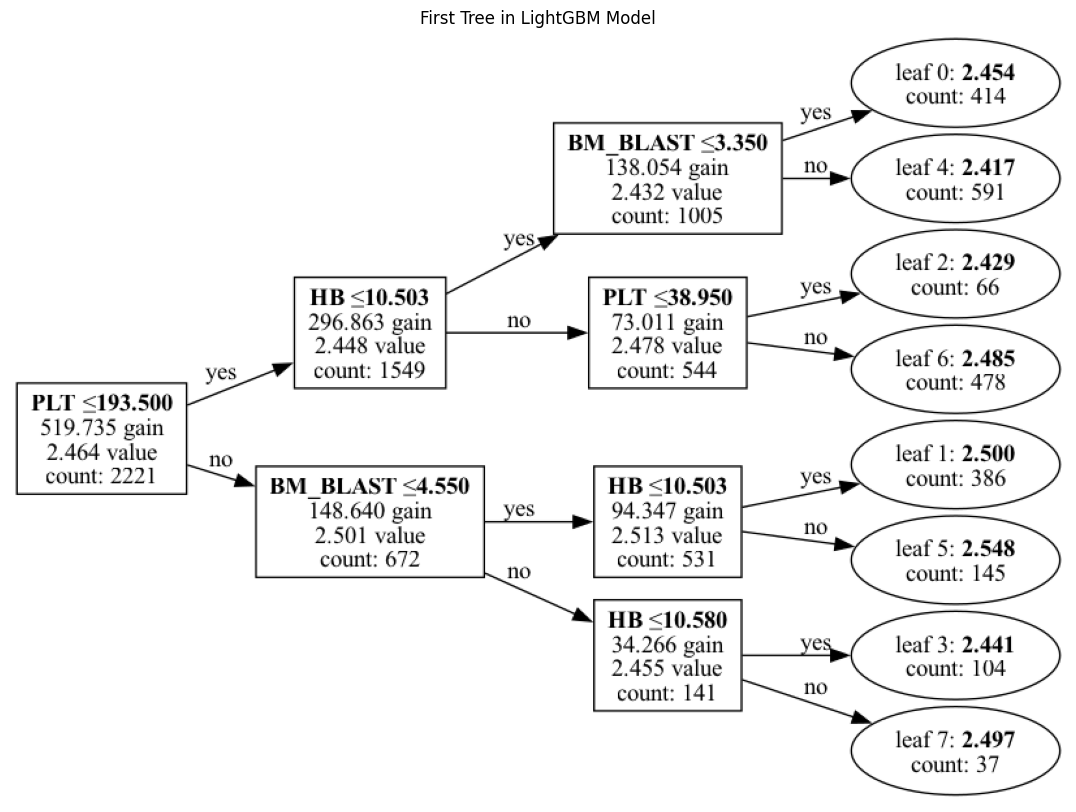

In [9]:
# Assuming the LightGBM model is defined as `model`
plt.figure(figsize=(20, 10))
lgb.plot_tree(model, tree_index=0, figsize=(20, 10), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
plt.title("First Tree in LightGBM Model")
plt.show()

### Step 4: Cox Proportional Hazards Model

To account for censoring in survival analysis, we use a Cox Proportional Hazards (Cox PH) model, a widely used method that estimates the effect of covariates on survival times without assuming a specific baseline survival distribution. The Cox PH model is based on the hazard function, $h(t | X)$, which represents the instantaneous risk of an event (e.g., death) at time $t$ given covariates $X$. The model assumes that the hazard can be expressed as:

$$h(t | X) = h_0(t) \exp(\beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p)$$


where $h_0(t)$ is the baseline hazard function, and $\beta$ values are coefficients for each covariate, representing the effect of $X$ on the hazard. Importantly, the proportional hazards assumption implies that the hazard ratios between individuals are constant over time. This approach effectively leverages both observed and censored survival times, making it a more suitable method for survival data compared to standard regression techniques that ignore censoring.


In [10]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.66
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.66


### Step 5: Naive Approach to Incorporate Mutations

In this step, we take a very naive approach to account for genetic mutations by simply counting the total number of somatic mutations per patient. Instead of analyzing specific mutations or their biological impact, we use this aggregate count as a basic feature to reflect the mutational burden for each individual. Although simplistic, this feature can serve as a general indicator of genetic variability across patients, which may influence survival outcomes. More sophisticated mutation analysis could be incorporated in future models to improve predictive power.


In [27]:
tmp

,ID,Nmut
0,P100000,6
1,P100001,2
2,P100002,2
3,P100004,1
4,P100006,5
...,...,...
3021,P132725,5
3022,P132726,1
3023,P132727,2
3024,P132728,5


In [11]:
maf_df

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0
...,...,...,...,...,...,...,...,...,...,...,...
10930,P131472,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN
10931,P131505,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN
10932,P131816,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN
10933,P132717,NaN,NaN,NaN,NaN,NaN,MLL,MLL_PTD,PTD,NaN,NaN


In [28]:
# Step: Extract the number of somatic mutations per patient
# Group by 'ID' and count the number of mutations (rows) per patient
tmp = maf_df.groupby('ID').size().reset_index(name='Nmut')

# Merge with the training dataset and replace missing values in 'Nmut' with 0
df_2 = df.merge(tmp, on='ID', how='left').fillna({'Nmut': 0})

In [30]:
df_2[df_2['Nmut'] == 0]

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,Nmut
5,P132701,MSK,3.0,15.8,12.60,0.88,8.0,492.0,"46,xx[20]",0.0
18,P132712,MSK,0.0,4.7,1.00,0.40,8.5,34.0,"46,xx[8]",0.0
20,P130764,MSK,4.0,3.4,1.70,0.20,10.7,248.0,"46,xx,t(7;12)(q11.2;p13)[20]",0.0
40,P106016,CCH,3.0,12.2,8.90,NaN,11.6,341.0,"46,xx[20]",0.0
55,P106072,CCH,3.0,5.0,2.90,0.60,9.5,201.0,"45,x,-y[15]/46,xy[5]",0.0
...,...,...,...,...,...,...,...,...,...,...
3212,P118240,UOB,3.0,4.6,2.53,0.32,9.5,377.0,"45,x,-y,-y[4]/46,xy[16]",0.0
3216,P118244,UOB,4.5,6.6,4.00,0.60,9.3,190.0,"46,xx[20]",0.0
3261,P102714,UOXF,1.0,4.6,2.60,NaN,10.1,233.0,"46,xx[20]",0.0
3266,P102720,UOXF,1.0,6.5,3.00,NaN,9.9,160.0,"46,xx[20]",0.0


In [13]:
# Select features
features = ['BM_BLAST', 'HB', 'PLT', 'Nmut']
target = ['OS_YEARS', 'OS_STATUS']

# Create the survival data format
X = df_2.loc[df_2['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[['BM_BLAST', 'HB', 'PLT', 'Nmut']] = imputer.fit_transform(X_train[['BM_BLAST', 'HB', 'PLT', 'Nmut']])
X_test[['BM_BLAST', 'HB', 'PLT', 'Nmut']] = imputer.transform(X_test[['BM_BLAST', 'HB', 'PLT', 'Nmut']])

In [16]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.68
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.68


### Inference on test set

In [17]:

tmp_eval = maf_eval.groupby('ID').size().reset_index(name='Nmut')

# Merge with the training dataset and replace missing values in 'Nmut' with 0
df_eval = df_eval.merge(tmp_eval, on='ID', how='left').fillna({'Nmut': 0})



In [18]:

df_eval[['BM_BLAST', 'HB', 'PLT', 'Nmut']] = imputer.transform(df_eval[['BM_BLAST', 'HB', 'PLT', 'Nmut']])

prediction_on_test_set = cox.predict(df_eval.loc[:, features])

In [19]:
prediction_on_test_set

array([ 0.86383926, -0.51383953, -1.73261271, ..., -1.69091907,
       -1.44228073, -1.5665999 ], shape=(1193,))

In [20]:
submission = pd.Series(prediction_on_test_set, index=df_eval['ID'], name='risk_score')

In [21]:
submission

ID
KYW1       0.863839
KYW2      -0.513840
KYW3      -1.732613
KYW4       0.493820
KYW5      -1.125188
             ...   
KYW1189   -1.566600
KYW1190   -1.442281
KYW1191   -1.690919
KYW1192   -1.442281
KYW1193   -1.566600
Name: risk_score, Length: 1193, dtype: float64

In [22]:

submission.to_csv('output/benchmark_submission.csv')

In [23]:
submission

ID
KYW1       0.863839
KYW2      -0.513840
KYW3      -1.732613
KYW4       0.493820
KYW5      -1.125188
             ...   
KYW1189   -1.566600
KYW1190   -1.442281
KYW1191   -1.690919
KYW1192   -1.442281
KYW1193   -1.566600
Name: risk_score, Length: 1193, dtype: float64

In [24]:

random_submission = pd.Series(np.random.uniform(0, 1, len(submission)),index =submission.index, name='OS_YEARS')


In [25]:
random_submission.to_csv('./random_submission.csv')

In [26]:
random_submission

ID
KYW1       0.529061
KYW2       0.879661
KYW3       0.163908
KYW4       0.312606
KYW5       0.510150
             ...   
KYW1189    0.433352
KYW1190    0.271393
KYW1191    0.843440
KYW1192    0.379578
KYW1193    0.146407
Name: OS_YEARS, Length: 1193, dtype: float64

In [32]:
features_defs

NameError: name 'features_defs' is not defined